In [2]:
def start_signature():
    print("="*40)
    print("START OF NOTEBOOK — AT")
    print("="*40)

start_signature()


START OF NOTEBOOK — AT


In [ ]:
import pandas as pd
import numpy as np

# lets look at the base table - transfers 
df_transfers = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\transfers.csv')
df_transfers.head()

In [2]:
# I want to know the unique number of patients and unique admissions 

unique_patients = df_transfers["subject_id"].nunique()
unique_admissions = df_transfers["hadm_id"].nunique()
unique_transfers = df_transfers["transfer_id"].nunique()
print("the no of unique patients :", unique_patients)
print(" the no of unique admissions :", unique_admissions)
print(" the no of unique transfers :", unique_transfers)

the no of unique patients : 364627
 the no of unique admissions : 546024
 the no of unique transfers : 2413581


In [3]:
df_transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413581 entries, 0 to 2413580
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   subject_id   int64  
 1   hadm_id      float64
 2   transfer_id  int64  
 3   eventtype    object 
 4   careunit     object 
 5   intime       object 
 6   outtime      object 
dtypes: float64(1), int64(2), object(4)
memory usage: 128.9+ MB


In [4]:
# i am gonna calculate our output variable now - time spent in ED. Now for that first I need only ED data , everything else not needed so need to remove that
# Secondly remove any blank values and then create a new variable called LOS_ED - length of stay in ED
# Goal is to predict how long a patient will stay in the ED during a single hospital visit, so we will  use the admission level.
# LOS_ED_houurs - defined as the time spent by a patient in emergency department calculated by the difference between intime and outtime 

units = ['Medicine']
df_transfers = df_transfers[df_transfers['careunit'].isin(units)].copy()
# df_transfers = df_transfers.dropna(subset =['intime','outtime'])

In [5]:
df_transfers.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
21,10000084,23052089.0,34537425,admit,Medicine,2160-11-21 03:20:00,2160-11-25 14:52:20
49,10000248,20600184.0,33331044,admit,Medicine,2192-11-30 03:32:00,2192-11-30 19:27:33
89,10000690,25860671.0,30317267,transfer,Medicine,2150-11-06 17:03:17,2150-11-12 13:49:47
93,10000690,26146595.0,32577424,admit,Medicine,2152-01-29 01:22:00,2152-01-30 15:57:02
131,10000904,28328117.0,31449664,admit,Medicine,2180-10-09 15:56:38,2180-10-09 22:09:07


In [6]:
# now lets keep datetime format and calculate LOS_HC (hours)
df_transfers['intime'] = pd.to_datetime(df_transfers['intime'])
df_transfers['outtime'] = pd.to_datetime(df_transfers['outtime'])

df_transfers['LOS_Medicine'] = (df_transfers['outtime']-df_transfers['intime']).dt.total_seconds()/3600

In [7]:
# lets aggregate at admission id level, need to sum the times spent in Emergency department and emergency department observation
# if a patient had multiple ED transfers hence why.
# keeping subject_id , so that if i want later can keep the count of patients 

df_transfers = df_transfers.groupby('hadm_id',as_index= False).agg({
    'LOS_Medicine':'sum',
    'subject_id':'first'}).rename(columns={'LOS_Medicine':'LOS_Medicine_hours'})

df_transfers['LOS_Medicine_hours']=df_transfers['LOS_Medicine_hours'].round(2)

In [8]:
print (df_transfers.head())

      hadm_id  LOS_Medicine_hours  subject_id
0  20000019.0               66.11    10467237
1  20000024.0               18.56    16925328
2  20000034.0               46.23    19430048
3  20000045.0              188.04    13413708
4  20000057.0               69.42    11146739


In [9]:
df_transfers.info()
#df_transfers.isnull().any().any()
df_transfers.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134836 entries, 0 to 134835
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   hadm_id             134836 non-null  float64
 1   LOS_Medicine_hours  134836 non-null  float64
 2   subject_id          134836 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 3.1 MB


hadm_id               0
LOS_Medicine_hours    0
subject_id            0
dtype: int64

In [10]:
df_transfers['LOS_Medicine_hours'].describe()

count    134836.000000
mean         98.288169
std         129.363100
min           0.000000
25%          31.480000
50%          66.130000
75%         118.560000
max        9039.230000
Name: LOS_Medicine_hours, dtype: float64

c:\Users\arpitha_work\anaconda3\envs\mimic\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


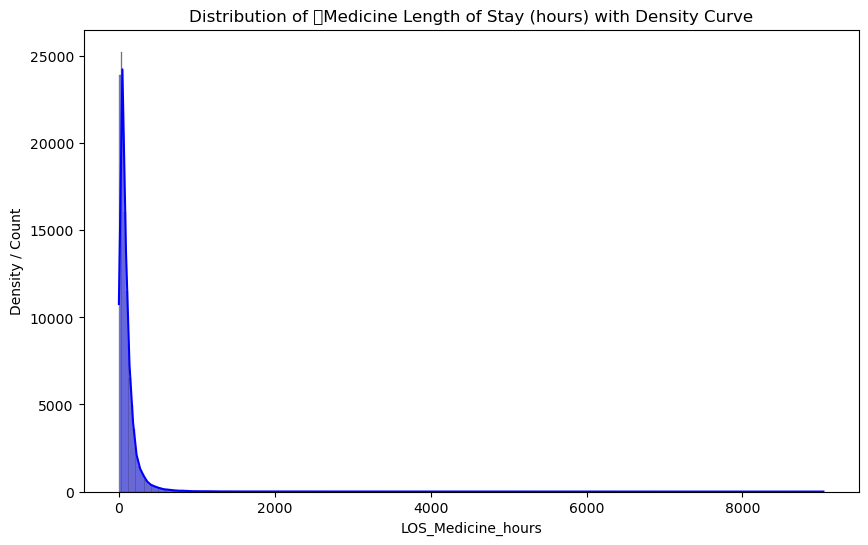

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(df_transfers['LOS_Medicine_hours'], bins=400, kde=True, color='blue')
plt.title('Distribution of 	Medicine Length of Stay (hours) with Density Curve')
plt.xlabel('LOS_Medicine_hours')
plt.ylabel('Density / Count')
plt.show()




In [12]:
df_transfers['LOS_Medicine_hours'].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95, 0.99])


count    134836.000000
mean         98.288169
std         129.363100
min           0.000000
25%          31.480000
50%          66.130000
75%         118.560000
90%         207.985000
95%         292.047500
99%         594.772500
max        9039.230000
Name: LOS_Medicine_hours, dtype: float64

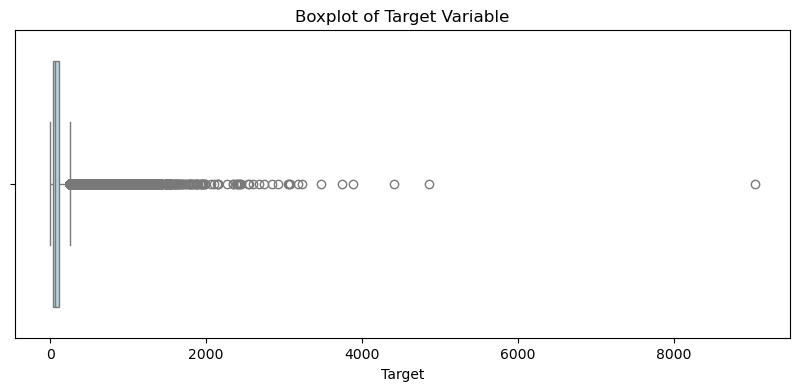

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.boxplot(x=df_transfers['LOS_Medicine_hours'], color='lightblue')
plt.title('Boxplot of Target Variable')
plt.xlabel('Target')
plt.show()


In [14]:
Q1 = df_transfers['LOS_Medicine_hours'].quantile(0.25)
Q3 = df_transfers['LOS_Medicine_hours'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

outliers = df_transfers[(df_transfers['LOS_Medicine_hours'] > upper_limit) | (df_transfers['LOS_Medicine_hours'] < lower_limit)]
print(f"Outlier count: {len(outliers)} ({len(outliers)/len(df_transfers)*100:.2f}% of total)")


Outlier count: 9419 (6.99% of total)


In [15]:
upper_limit = df_transfers['LOS_Medicine_hours'].quantile(0.75) + 1.5 * (df_transfers['LOS_Medicine_hours'].quantile(0.75) - df_transfers['LOS_Medicine_hours'].quantile(0.25))
print("Upper limit (IQR method):", upper_limit)

df_transfers.loc[df_transfers['LOS_Medicine_hours'] > upper_limit, 'LOS_Medicine_hours'].describe()


Upper limit (IQR method): 249.18


count    9419.000000
mean      433.335134
std       278.061138
min       249.220000
25%       286.595000
50%       348.390000
75%       474.840000
max      9039.230000
Name: LOS_Medicine_hours, dtype: float64

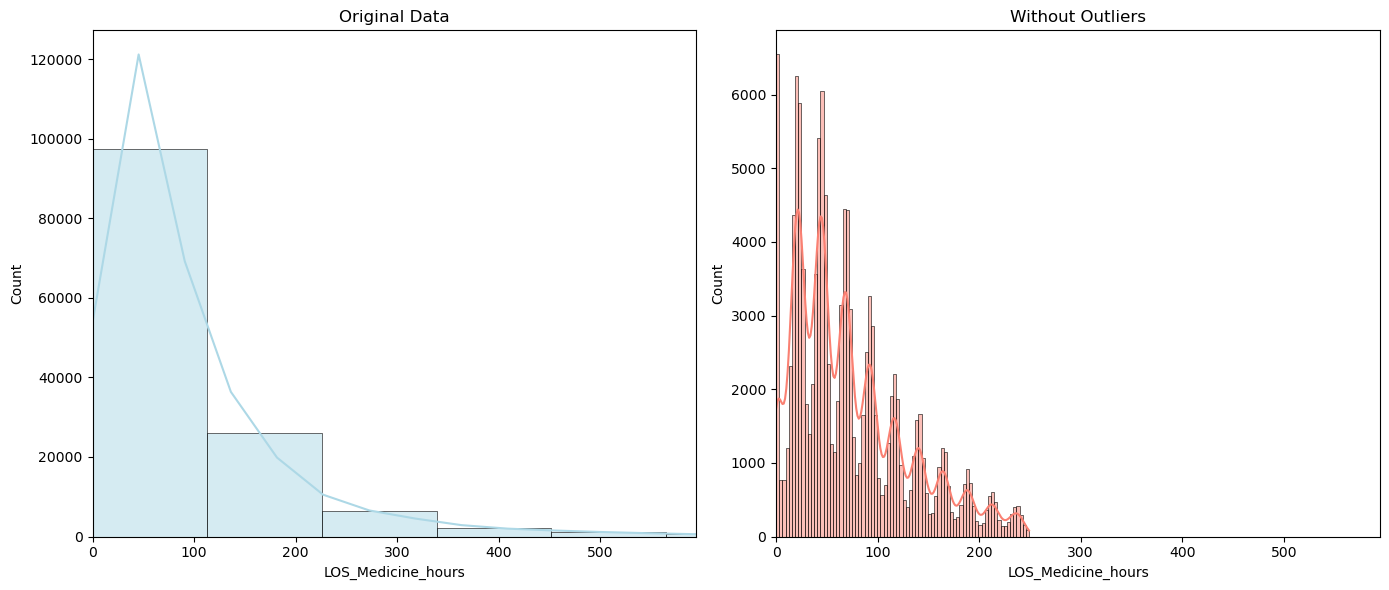

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Original
sns.histplot(df_transfers['LOS_Medicine_hours'], kde=True, bins=80, color='lightblue', stat='count', ax=axes[0])
axes[0].set_xlim(0, df_transfers['LOS_Medicine_hours'].quantile(0.99))
axes[0].set_title('Original Data')

# Without outliers
sns.histplot(df_transfers.loc[df_transfers['LOS_Medicine_hours'] <= upper_limit, 'LOS_Medicine_hours'], kde=True, bins=80, color='salmon', stat='count', ax=axes[1])
axes[1].set_xlim(0, df_transfers['LOS_Medicine_hours'].quantile(0.99))
axes[1].set_title('Without Outliers')

plt.tight_layout()
plt.show()


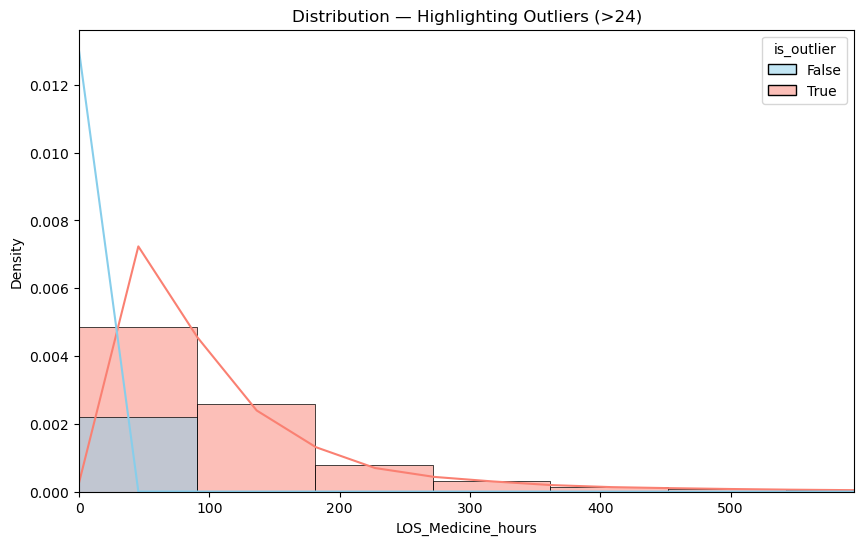

In [17]:
df_transfers['is_outlier'] = df_transfers['LOS_Medicine_hours'] > 24

plt.figure(figsize=(10,6))
sns.histplot(data=df_transfers, x='LOS_Medicine_hours', hue='is_outlier', bins=100, stat='density',
             palette={False: 'skyblue', True: 'salmon'}, kde=True)
plt.xlim(0, df_transfers['LOS_Medicine_hours'].quantile(0.99))
plt.title('Distribution — Highlighting Outliers (>24)')
plt.show()


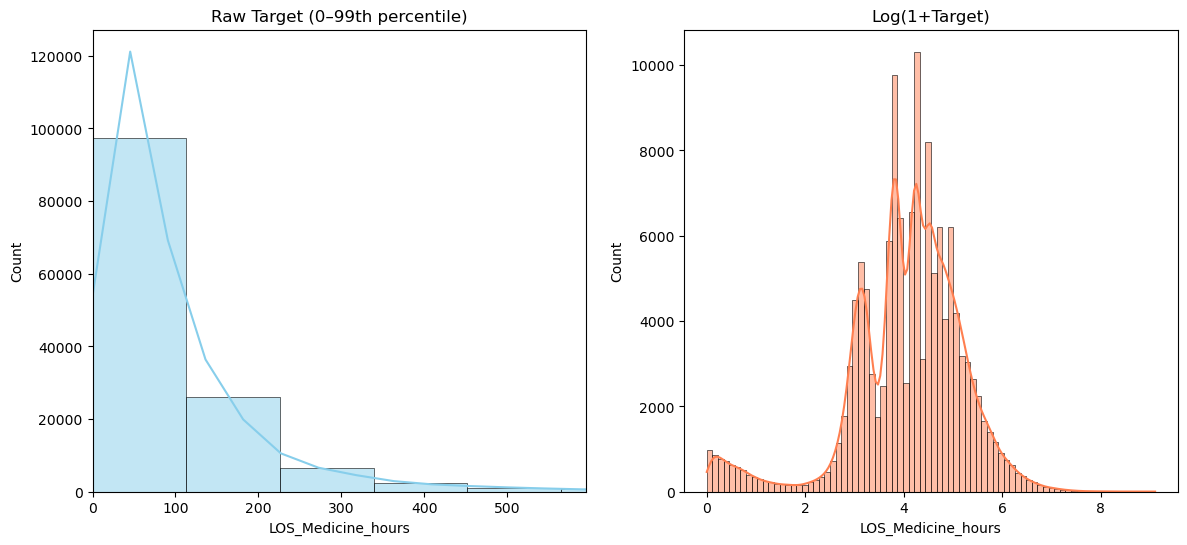

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.histplot(df_transfers['LOS_Medicine_hours'], kde=True, bins=80, stat='count', color='skyblue', ax=axes[0])
axes[0].set_xlim(0, df_transfers['LOS_Medicine_hours'].quantile(0.99))
axes[0].set_title('Raw Target (0–99th percentile)')

sns.histplot(np.log1p(df_transfers['LOS_Medicine_hours']), kde=True, bins=80, stat='count', color='coral', ax=axes[1])
axes[1].set_title('Log(1+Target)')

plt.show()


In [19]:
df_patients = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\patients.csv')
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364627 entries, 0 to 364626
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         364627 non-null  int64 
 1   gender             364627 non-null  object
 2   anchor_age         364627 non-null  int64 
 3   anchor_year        364627 non-null  int64 
 4   anchor_year_group  364627 non-null  object
 5   dod                38301 non-null   object
dtypes: int64(3), object(3)
memory usage: 16.7+ MB


In [20]:
df_patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [21]:
df_patients.isnull().sum()

subject_id                0
gender                    0
anchor_age                0
anchor_year               0
anchor_year_group         0
dod                  326326
dtype: int64

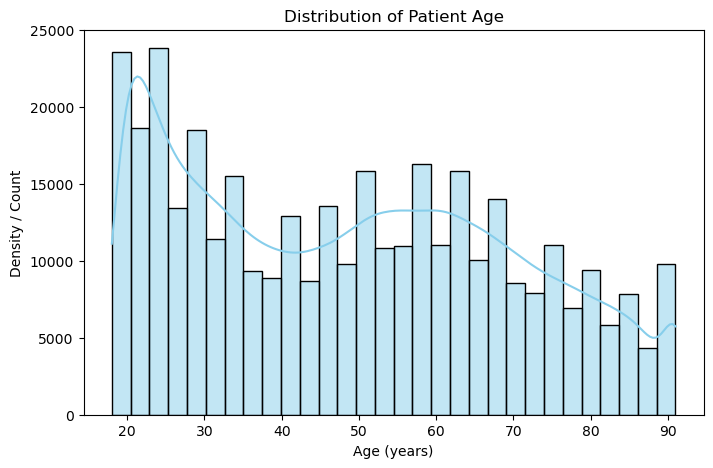

In [22]:
plt.figure(figsize=(8,5))
sns.histplot(df_patients['anchor_age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Patient Age')
plt.xlabel('Age (years)')
plt.ylabel('Density / Count')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\3863528105.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df_patients, palette='pastel')


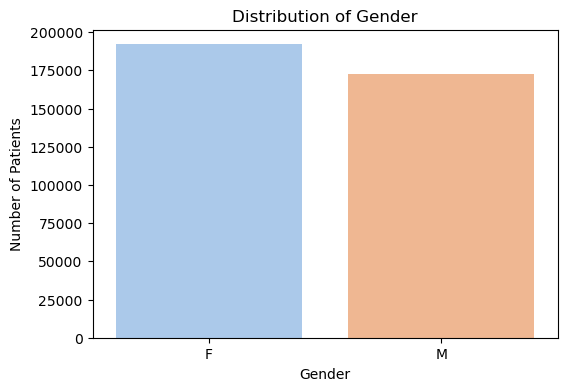

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df_patients, palette='pastel')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.show()


In [24]:
# lets keep only required columns in patients table
df_patients = df_patients.drop(columns=['anchor_year','anchor_year_group','dod'])

In [25]:
df_merge1=df_transfers.merge(df_patients,on='subject_id',how='left')
df_merge1.head()

,hadm_id,LOS_Medicine_hours,subject_id,is_outlier,gender,anchor_age
0,20000019.0,66.11,10467237,True,F,76
1,20000024.0,18.56,16925328,False,F,84
2,20000034.0,46.23,19430048,True,M,72
3,20000045.0,188.04,13413708,True,F,51
4,20000057.0,69.42,11146739,True,F,91


In [26]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134836 entries, 0 to 134835
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   hadm_id             134836 non-null  float64
 1   LOS_Medicine_hours  134836 non-null  float64
 2   subject_id          134836 non-null  int64  
 3   is_outlier          134836 non-null  bool   
 4   gender              134836 non-null  object 
 5   anchor_age          134836 non-null  int64  
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 5.3+ MB


In [27]:
df_merge1=df_merge1[df_merge1['anchor_age'] >=65]
df_merge1.head()

,hadm_id,LOS_Medicine_hours,subject_id,is_outlier,gender,anchor_age
0,20000019.0,66.11,10467237,True,F,76
1,20000024.0,18.56,16925328,False,F,84
2,20000034.0,46.23,19430048,True,M,72
4,20000057.0,69.42,11146739,True,F,91
6,20000214.0,50.37,18327790,True,M,68


In [28]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61181 entries, 0 to 134833
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hadm_id             61181 non-null  float64
 1   LOS_Medicine_hours  61181 non-null  float64
 2   subject_id          61181 non-null  int64  
 3   is_outlier          61181 non-null  bool   
 4   gender              61181 non-null  object 
 5   anchor_age          61181 non-null  int64  
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 2.9+ MB


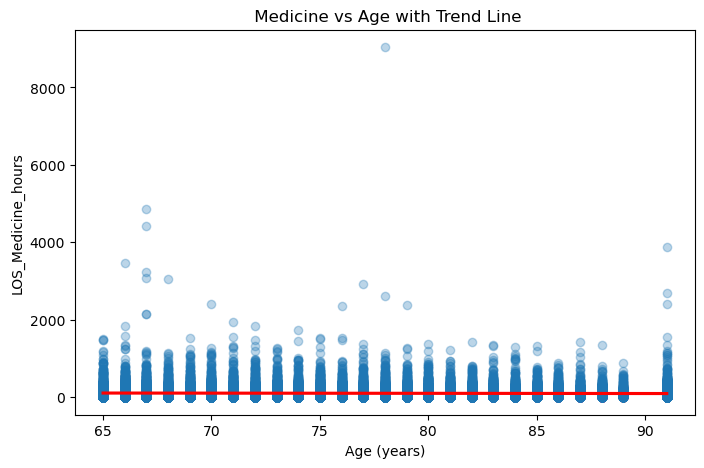

In [29]:
plt.figure(figsize=(8,5))
sns.regplot(x='anchor_age', y='LOS_Medicine_hours', data=df_merge1, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(' Medicine vs Age with Trend Line')
plt.xlabel('Age (years)')
plt.ylabel('LOS_Medicine_hours')
plt.show()


In [30]:
corr = df_merge1['anchor_age'].corr(df_merge1['LOS_Medicine_hours'])
print(f"Correlation between age and Medicine LOS: {corr:.2f}")


Correlation between age and Medicine LOS: -0.03


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\1421078966.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='LOS_Medicine_hours', data=df_merge1, palette='viridis')


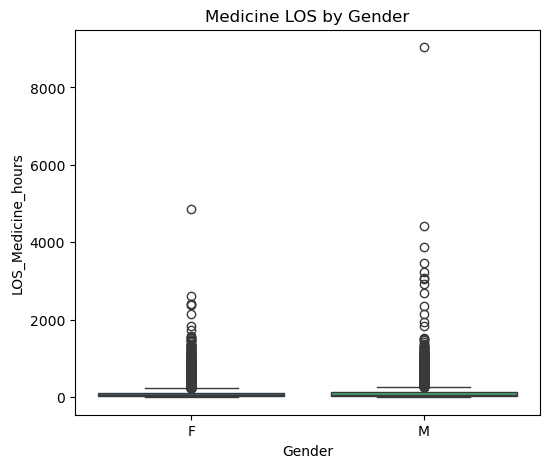

In [31]:
plt.figure(figsize=(6,5))
sns.boxplot(x='gender', y='LOS_Medicine_hours', data=df_merge1, palette='viridis')
plt.title('Medicine LOS by Gender')
plt.xlabel('Gender')
plt.ylabel('LOS_Medicine_hours')
plt.show()


In [32]:
df_admissions = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\admissions.csv')
df_admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [33]:
df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            546028 non-null  int64 
 1   hadm_id               546028 non-null  int64 
 2   admittime             546028 non-null  object
 3   dischtime             546028 non-null  object
 4   deathtime             11790 non-null   object
 5   admission_type        546028 non-null  object
 6   admit_provider_id     546024 non-null  object
 7   admission_location    546027 non-null  object
 8   discharge_location    396210 non-null  object
 9   insurance             536673 non-null  object
 10  language              545253 non-null  object
 11  marital_status        532409 non-null  object
 12  race                  546028 non-null  object
 13  edregtime             379240 non-null  object
 14  edouttime             379240 non-null  object
 15  hospital_expire_f

In [34]:
df_admissions = df_admissions.drop(columns=['dischtime','discharge_location','language',
                                            'edregtime','edouttime','hospital_expire_flag','deathtime'])

In [35]:
df_admissions = df_admissions.dropna(subset=['marital_status'])


In [36]:
df_admissions.isnull().sum()

subject_id               0
hadm_id                  0
admittime                0
admission_type           0
admit_provider_id        4
admission_location       0
insurance             8283
marital_status           0
race                     0
dtype: int64

In [37]:
df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532409 entries, 0 to 546026
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   subject_id          532409 non-null  int64 
 1   hadm_id             532409 non-null  int64 
 2   admittime           532409 non-null  object
 3   admission_type      532409 non-null  object
 4   admit_provider_id   532405 non-null  object
 5   admission_location  532409 non-null  object
 6   insurance           524126 non-null  object
 7   marital_status      532409 non-null  object
 8   race                532409 non-null  object
dtypes: int64(2), object(7)
memory usage: 40.6+ MB


In [38]:
#lets understand about provider

df_admissions['admit_provider_id'].nunique()

2038

In [39]:
patients_per_doctor = df_admissions.groupby('admit_provider_id')['subject_id'].nunique().reset_index()
patients_per_doctor.rename(columns={'subject_id': 'unique_patients'}, inplace=True)

print(patients_per_doctor)

     admit_provider_id  unique_patients
0               P00230                1
1               P004G6               20
2               P005Y0                1
3               P00628              214
4               P007EI              107
...                ...              ...
2033            P99GVJ              408
2034            P99MV4              421
2035            P99V46              201
2036            P99X3Q               42
2037            P99Z33               23

[2038 rows x 2 columns]


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\792934700.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='admission_type', data=df_admissions, palette='Set2')


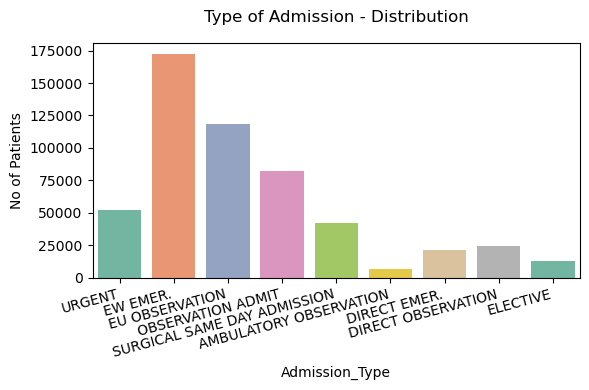

In [40]:
plt.figure(figsize=(6,4))
sns.countplot(x='admission_type', data=df_admissions, palette='Set2')
plt.title('Type of Admission - Distribution', pad=15)   
plt.xlabel('Admission_Type')
plt.ylabel('No of Patients')

# trying to rotate axis coz the titles were overlapping here
plt.xticks(rotation=15, ha='right') 
plt.tight_layout()
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\1013477000.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='admission_location', data=df_admissions, palette='Set2')


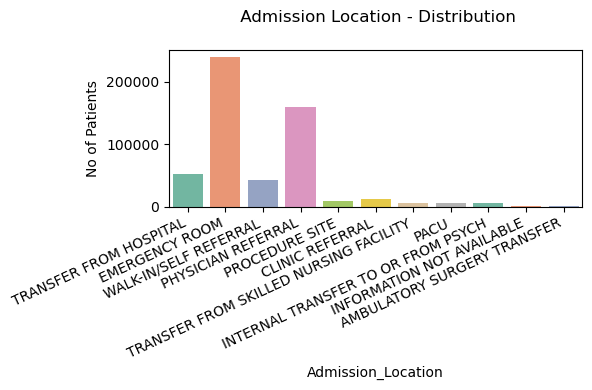

In [41]:
plt.figure(figsize=(6,4))
sns.countplot(x='admission_location', data=df_admissions, palette='Set2')
plt.title(' Admission Location - Distribution', pad=20)   
plt.xlabel('Admission_Location')
plt.ylabel('No of Patients')

# trying to rotate axis coz the titles were overlapping here
plt.xticks(rotation=25, ha='right') 
plt.tight_layout()
plt.show()


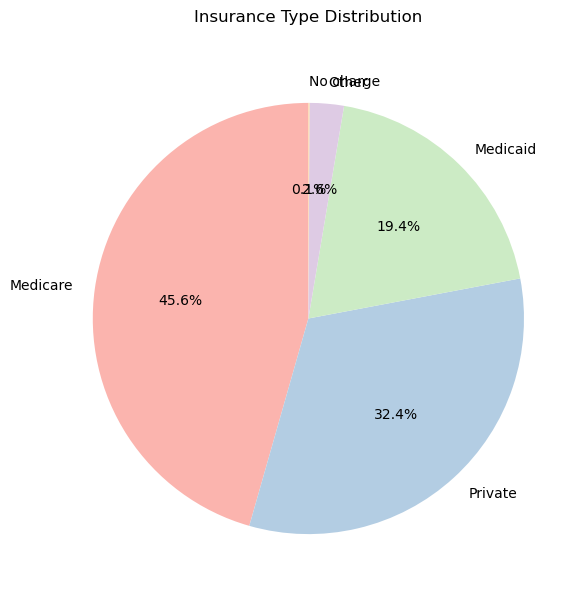

In [42]:
insurance_counts = df_admissions['insurance'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    insurance_counts, 
    labels=insurance_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel1.colors
)
plt.title('Insurance Type Distribution', pad=20)
plt.show()


In [43]:
df_merge2 = pd.merge(df_merge1, df_admissions, on=['hadm_id','subject_id'], how='inner')
#using inner here instead of left coz i need matching records from both tables.

In [44]:
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59817 entries, 0 to 59816
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hadm_id             59817 non-null  float64
 1   LOS_Medicine_hours  59817 non-null  float64
 2   subject_id          59817 non-null  int64  
 3   is_outlier          59817 non-null  bool   
 4   gender              59817 non-null  object 
 5   anchor_age          59817 non-null  int64  
 6   admittime           59817 non-null  object 
 7   admission_type      59817 non-null  object 
 8   admit_provider_id   59816 non-null  object 
 9   admission_location  59817 non-null  object 
 10  insurance           59678 non-null  object 
 11  marital_status      59817 non-null  object 
 12  race                59817 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 5.5+ MB


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\3636165502.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='insurance', x='LOS_Medicine_hours', data=df_merge2, palette='Set2')


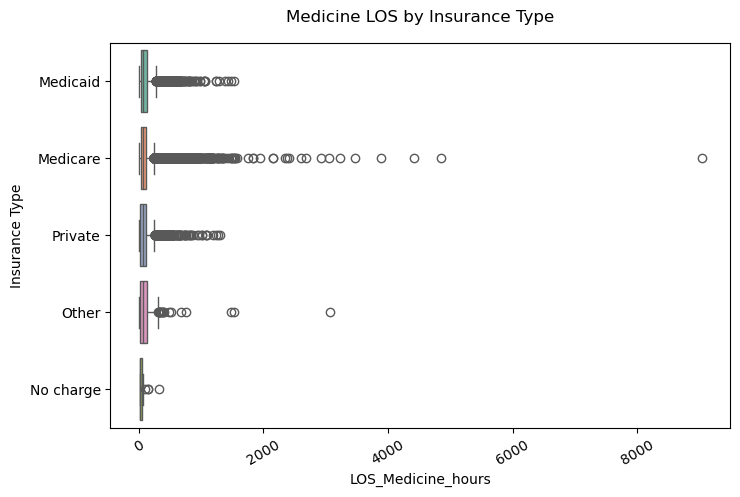

In [45]:
plt.figure(figsize=(8,5))
sns.boxplot(y='insurance', x='LOS_Medicine_hours', data=df_merge2, palette='Set2')
plt.title('Medicine LOS by Insurance Type', pad=15)
plt.xlabel('LOS_Medicine_hours')
plt.ylabel('Insurance Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\318704288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='admission_type', x='LOS_Medicine_hours', data=df_merge2, palette='Set2')


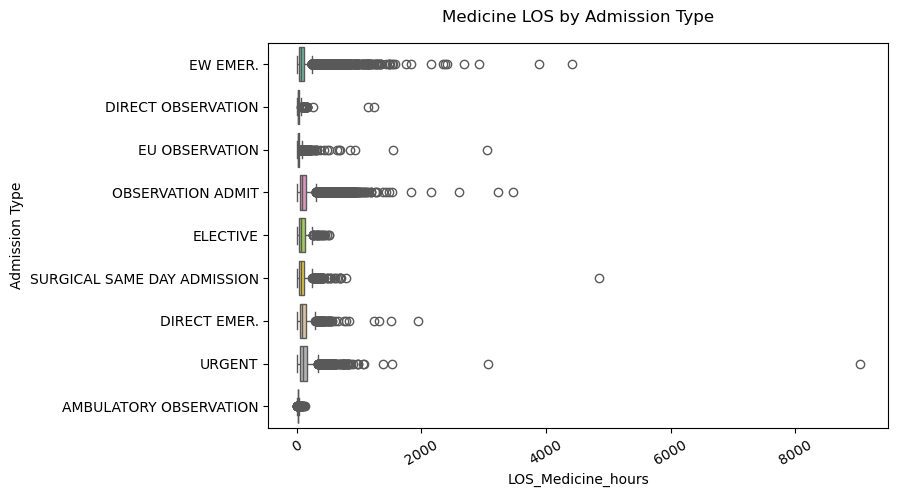

In [46]:
plt.figure(figsize=(8,5))
sns.boxplot(y='admission_type', x='LOS_Medicine_hours', data=df_merge2, palette='Set2')
plt.title('Medicine LOS by Admission Type', pad=15)
plt.xlabel('LOS_Medicine_hours')
plt.ylabel('Admission Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


In [47]:
df_merge2['LOS_Medicine_hours'].describe()

count    59817.000000
mean       101.074371
std        127.551240
min          0.000000
25%         37.990000
50%         69.300000
75%        122.950000
max       9039.230000
Name: LOS_Medicine_hours, dtype: float64

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\1110338048.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


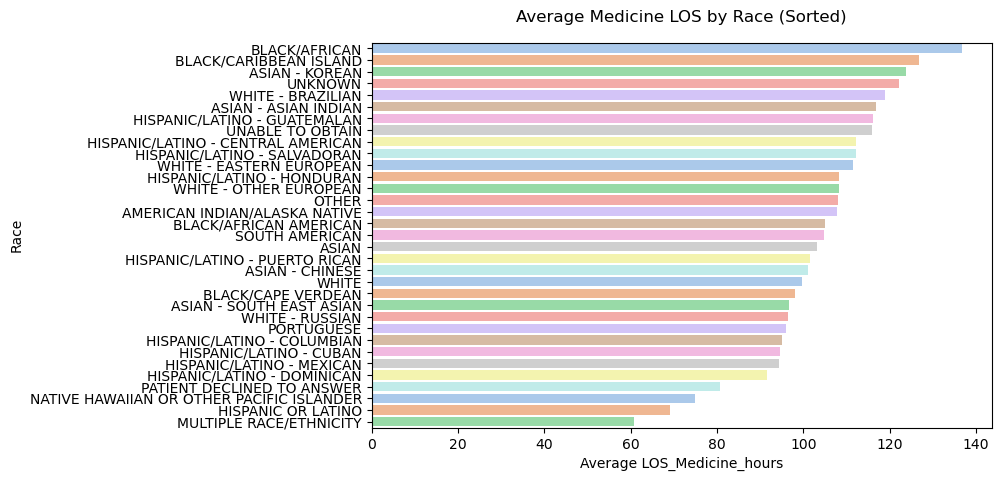

In [48]:
mean_los_race = df_merge2.groupby('race')['LOS_Medicine_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Medicine_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='race', 
    x='LOS_Medicine_hours', 
    data=mean_los_race,
    palette='pastel'
)
plt.title('Average Medicine LOS by Race (Sorted)', pad=15)
plt.xlabel('Average LOS_Medicine_hours')
plt.ylabel('Race')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\2670053824.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


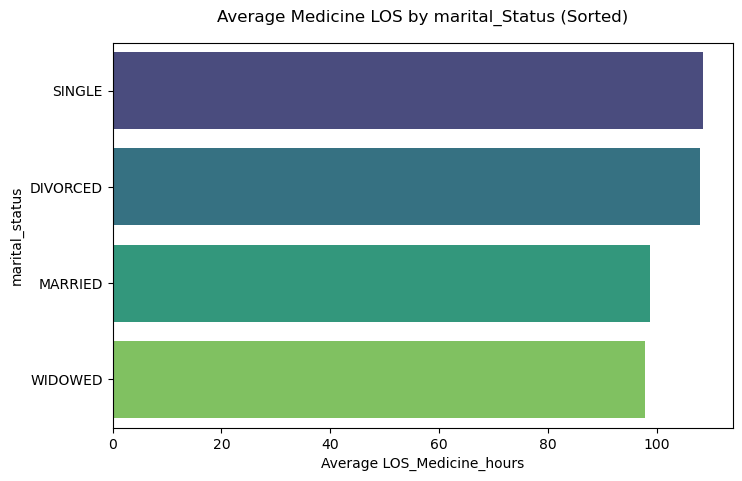

In [49]:
mean_los_race = df_merge2.groupby('marital_status')['LOS_Medicine_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Medicine_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='marital_status', 
    x='LOS_Medicine_hours', 
    data=mean_los_race,
    palette='viridis'
)
plt.title('Average Medicine LOS by marital_Status (Sorted)', pad=15)
plt.xlabel('Average LOS_Medicine_hours')
plt.ylabel('marital_status')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\3659109473.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


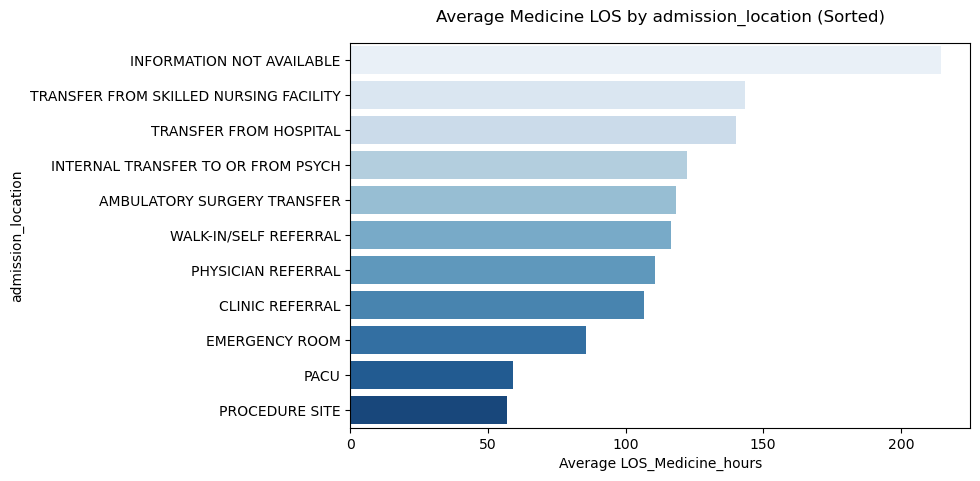

In [50]:
mean_los_race = df_merge2.groupby('admission_location')['LOS_Medicine_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Medicine_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='admission_location', 
    x='LOS_Medicine_hours', 
    data=mean_los_race,
    palette='Blues'
)
plt.title('Average Medicine LOS by admission_location (Sorted)', pad=15)
plt.xlabel('Average LOS_Medicine_hours')
plt.ylabel('admission_location')
plt.show()


In [51]:
df_merge2 = pd.merge(df_merge1, df_admissions, on=['hadm_id','subject_id'], how='inner')
#using inner here instead of left coz i need matching records from both tables.

In [52]:
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59817 entries, 0 to 59816
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hadm_id             59817 non-null  float64
 1   LOS_Medicine_hours  59817 non-null  float64
 2   subject_id          59817 non-null  int64  
 3   is_outlier          59817 non-null  bool   
 4   gender              59817 non-null  object 
 5   anchor_age          59817 non-null  int64  
 6   admittime           59817 non-null  object 
 7   admission_type      59817 non-null  object 
 8   admit_provider_id   59816 non-null  object 
 9   admission_location  59817 non-null  object 
 10  insurance           59678 non-null  object 
 11  marital_status      59817 non-null  object 
 12  race                59817 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 5.5+ MB


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\3636165502.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='insurance', x='LOS_Medicine_hours', data=df_merge2, palette='Set2')


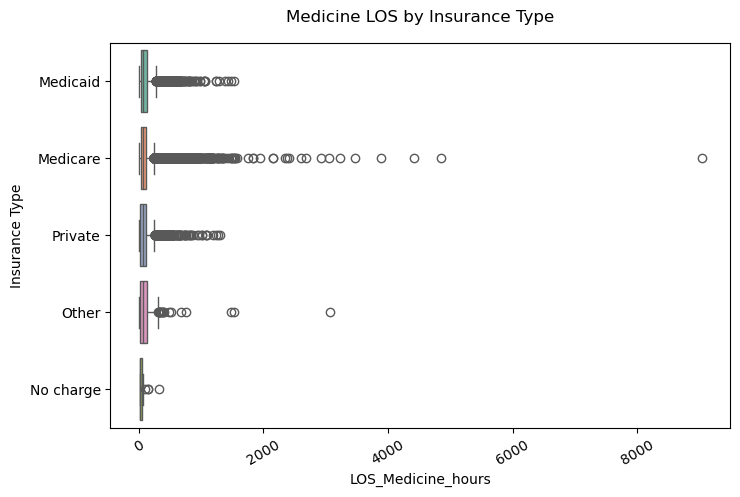

In [53]:
plt.figure(figsize=(8,5))
sns.boxplot(y='insurance', x='LOS_Medicine_hours', data=df_merge2, palette='Set2')
plt.title('Medicine LOS by Insurance Type', pad=15)
plt.xlabel('LOS_Medicine_hours')
plt.ylabel('Insurance Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\318704288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='admission_type', x='LOS_Medicine_hours', data=df_merge2, palette='Set2')


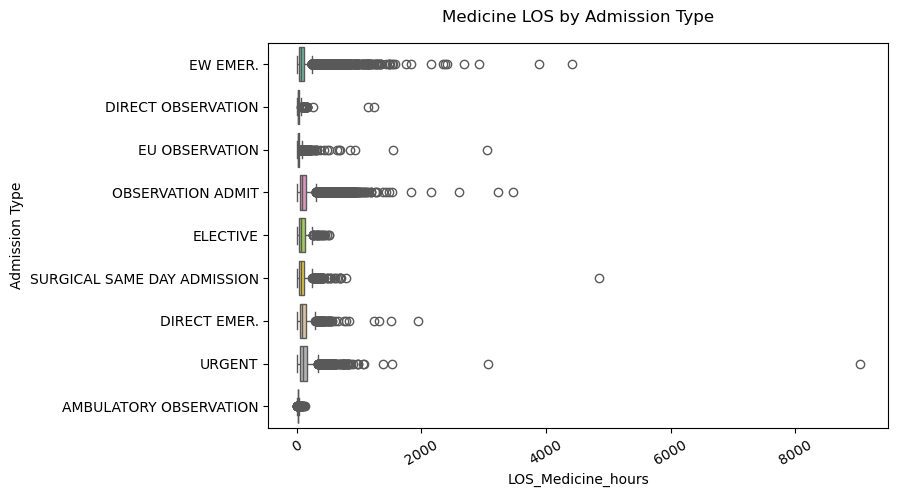

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(y='admission_type', x='LOS_Medicine_hours', data=df_merge2, palette='Set2')
plt.title('Medicine LOS by Admission Type', pad=15)
plt.xlabel('LOS_Medicine_hours')
plt.ylabel('Admission Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


In [55]:
df_merge2['LOS_Medicine_hours'].describe()

count    59817.000000
mean       101.074371
std        127.551240
min          0.000000
25%         37.990000
50%         69.300000
75%        122.950000
max       9039.230000
Name: LOS_Medicine_hours, dtype: float64

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\1110338048.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


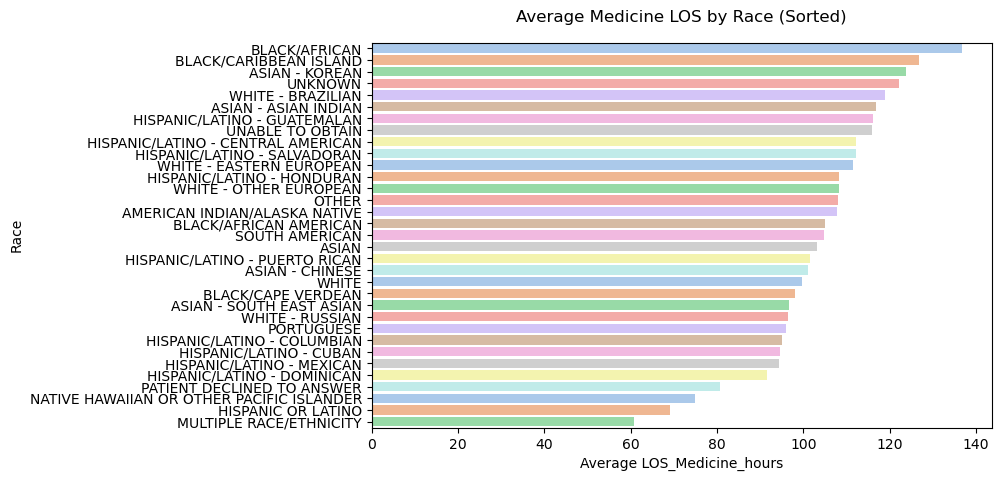

In [56]:
mean_los_race = df_merge2.groupby('race')['LOS_Medicine_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Medicine_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='race', 
    x='LOS_Medicine_hours', 
    data=mean_los_race,
    palette='pastel'
)
plt.title('Average Medicine LOS by Race (Sorted)', pad=15)
plt.xlabel('Average LOS_Medicine_hours')
plt.ylabel('Race')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\2670053824.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


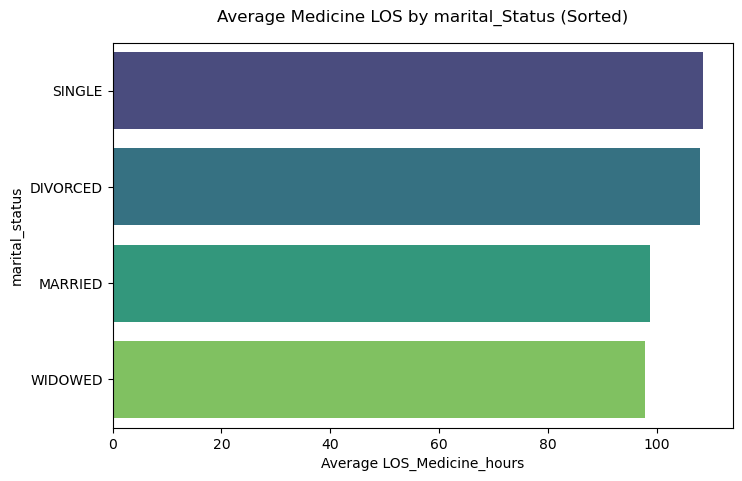

In [57]:
mean_los_race = df_merge2.groupby('marital_status')['LOS_Medicine_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Medicine_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='marital_status', 
    x='LOS_Medicine_hours', 
    data=mean_los_race,
    palette='viridis'
)
plt.title('Average Medicine LOS by marital_Status (Sorted)', pad=15)
plt.xlabel('Average LOS_Medicine_hours')
plt.ylabel('marital_status')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\3659109473.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


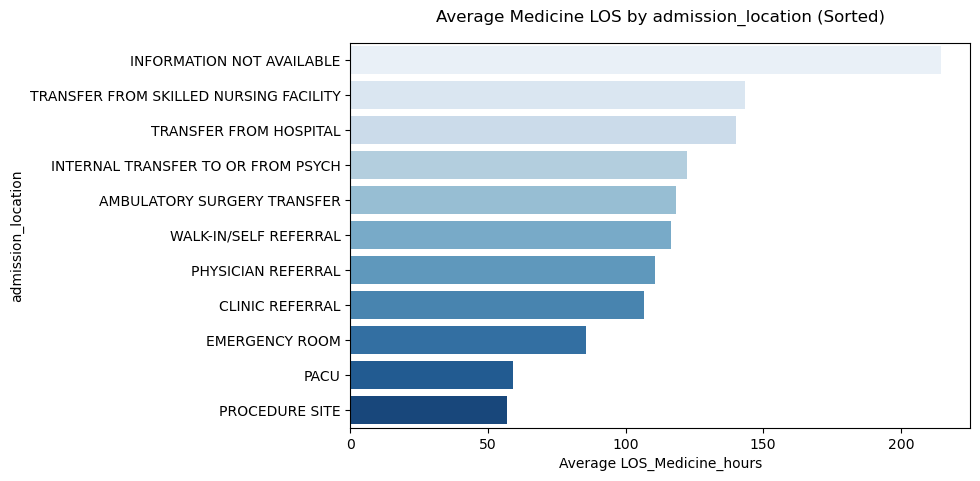

In [58]:
mean_los_race = df_merge2.groupby('admission_location')['LOS_Medicine_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Medicine_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='admission_location', 
    x='LOS_Medicine_hours', 
    data=mean_los_race,
    palette='Blues'
)
plt.title('Average Medicine LOS by admission_location (Sorted)', pad=15)
plt.xlabel('Average LOS_Medicine_hours')
plt.ylabel('admission_location')
plt.show()


In [59]:
df_merge2['admittime'] = pd.to_datetime(df_merge2['admittime'], errors='coerce')
df_merge2['admit_hour'] = df_merge2['admittime'].dt.hour
df_merge2['admit_day'] = df_merge2['admittime'].dt.dayofweek  # 0=Monday, 6=Sunday


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\3620575087.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='admit_hour', y='LOS_Medicine_hours', data=df_merge2, palette='pastel')


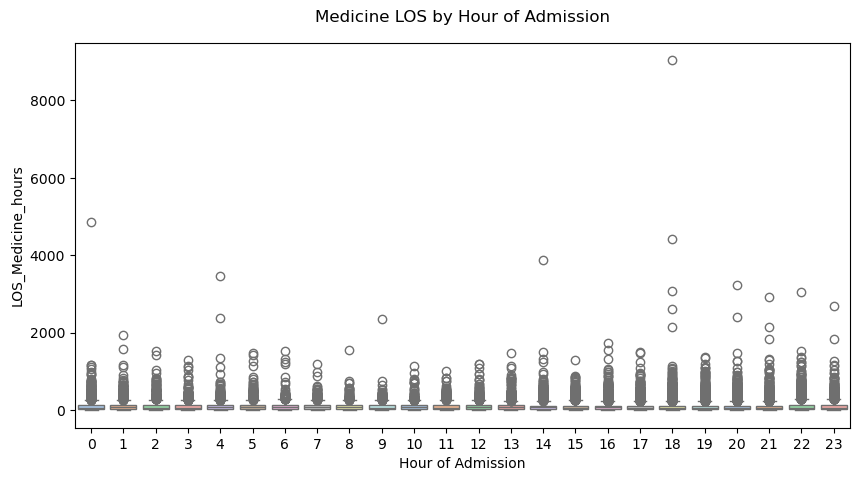

In [60]:
plt.figure(figsize=(10,5))
sns.boxplot(x='admit_hour', y='LOS_Medicine_hours', data=df_merge2, palette='pastel')
plt.title('Medicine LOS by Hour of Admission', pad=15)
plt.xlabel('Hour of Admission')
plt.ylabel('LOS_Medicine_hours')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\2484565426.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='admit_day', y='LOS_Medicine_hours', data=df_merge2, palette='Set2')


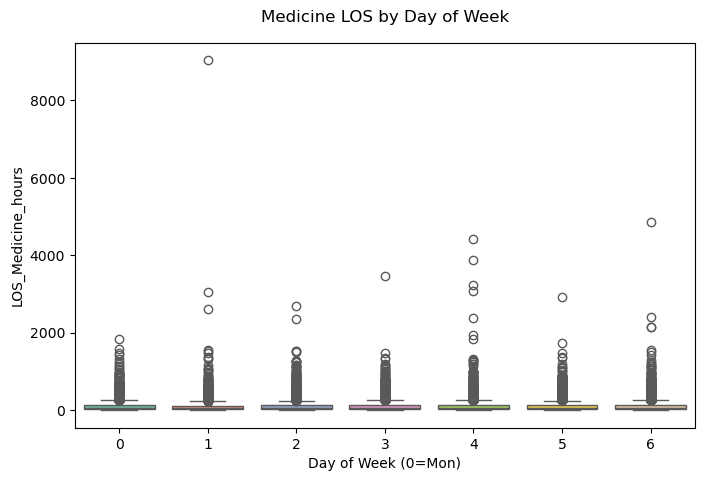

In [61]:
plt.figure(figsize=(8,5))
sns.boxplot(x='admit_day', y='LOS_Medicine_hours', data=df_merge2, palette='Set2')
plt.title('Medicine LOS by Day of Week', pad=15)
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('LOS_Medicine_hours')
plt.show()


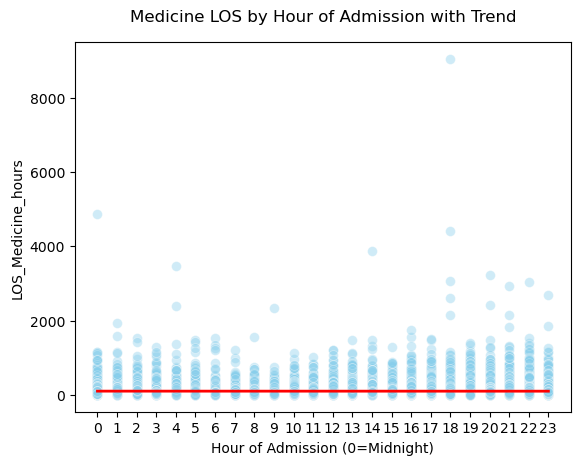

In [62]:
sns.scatterplot(
    x='admit_hour',
    y='LOS_Medicine_hours',
    data=df_merge2,
    color='skyblue',
    alpha=0.4,
    s=50
)

sns.regplot(
    x='admit_hour',
    y='LOS_Medicine_hours',
    data=df_merge2,
    scatter=False,          
    color='red',
    line_kws={'lw':2}
)

plt.title('Medicine LOS by Hour of Admission with Trend', pad=15)
plt.xlabel('Hour of Admission (0=Midnight)')
plt.ylabel('LOS_Medicine_hours')
plt.xticks(range(0,24))
plt.show()


In [63]:
file_path = r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\diagnoses_icd.csv.gz'
df_diagnoses = pd.read_csv(file_path, compression ='gzip')
df_diagnoses.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [64]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagnoses['icd_code'].value_counts().count()))

There are 28562 unique ICD9 codes in this dataset.


In [65]:
def categorize_icd9_short(code):
    """Return short ICD-9 category name"""
    if pd.isna(code):
        return 'misc'
    
    code_str = str(code).strip().upper()
    if code_str.startswith(('E', 'V')):
        return 'misc'  
    
    try:
        num = int(code_str[:3])
    except ValueError:
        return 'misc'
    
    ranges = [
        ((1, 139), 'infectious'),
        ((140, 239), 'neoplasms'),
        ((240, 279), 'endocrine'),
        ((280, 289), 'blood'),
        ((290, 319), 'mental'),
        ((320, 389), 'nervous'),
        ((390, 459), 'circulatory'),
        ((460, 519), 'respiratory'),
        ((520, 579), 'digestive'),
        ((580, 629), 'genitourinary'),
        ((630, 679), 'pregnancy'),
        ((680, 709), 'skin'),
        ((710, 739), 'muscular'),
        ((740, 759), 'congenital'),
        ((760, 779), 'prenatal'),
        ((780, 799), 'misc'),
        ((800, 999), 'injury')
    ]
    
    for (low, high), label in ranges:
        if low <= num <= high:
            return label
    return 'misc'

In [66]:
df_diagnoses['icd_category'] = df_diagnoses['icd_code'].apply(categorize_icd9_short)

diag_counts = (
    df_diagnoses.groupby(['hadm_id', 'icd_category'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

In [67]:
df_merge2 = df_merge2.merge(diag_counts, on='hadm_id', how='left')

In [68]:

df_merge2.fillna(0, inplace=True)

for col in diag_counts.columns:
    if col != 'hadm_id':
        df_merge2[col] = df_merge2[col].astype(int)


print(df_merge2.shape)
df_merge2.info()

(59817, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59817 entries, 0 to 59816
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   hadm_id             59817 non-null  float64       
 1   LOS_Medicine_hours  59817 non-null  float64       
 2   subject_id          59817 non-null  int64         
 3   is_outlier          59817 non-null  bool          
 4   gender              59817 non-null  object        
 5   anchor_age          59817 non-null  int64         
 6   admittime           59817 non-null  datetime64[ns]
 7   admission_type      59817 non-null  object        
 8   admit_provider_id   59817 non-null  object        
 9   admission_location  59817 non-null  object        
 10  insurance           59817 non-null  object        
 11  marital_status      59817 non-null  object        
 12  race                59817 non-null  object        
 13  admit_hour          59817 non-null

In [69]:
df_merge2.head()

,hadm_id,LOS_Medicine_hours,subject_id,is_outlier,gender,anchor_age,admittime,admission_type,admit_provider_id,admission_location,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,20000019.0,66.11,10467237,True,F,76,2159-03-20 21:08:00,EW EMER.,P28XL8,EMERGENCY ROOM,...,1,0,1,0,0,0,0,0,1,0
1,20000024.0,18.56,16925328,False,F,84,2151-05-25 21:44:00,EW EMER.,P43DGE,EMERGENCY ROOM,...,0,0,10,0,0,0,0,0,0,0
2,20000034.0,46.23,19430048,True,M,72,2174-05-22 19:13:00,DIRECT OBSERVATION,P28KC2,PHYSICIAN REFERRAL,...,0,0,28,0,0,0,0,0,0,0
3,20000057.0,69.42,11146739,True,F,91,2190-01-15 17:07:00,EU OBSERVATION,P55EL5,EMERGENCY ROOM,...,1,0,8,5,0,4,0,0,2,0
4,20000214.0,50.37,18327790,True,M,68,2114-05-08 13:50:00,EW EMER.,P784FA,PHYSICIAN REFERRAL,...,0,0,13,0,0,0,0,0,0,0


In [70]:
diseases = [
    'blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
    'genitourinary', 'infectious', 'injury', 'mental', 'misc',
    'muscular', 'neoplasms', 'nervous', 'respiratory', 'skin'
]

mean_los = {}
for disease in diseases:
    mean_los[disease] = df_merge2.loc[df_merge2[disease] > 0, 'LOS_Medicine_hours'].mean()

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_73820\738606594.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=list(mean_los.keys()), y=list(mean_los.values()), palette='viridis')


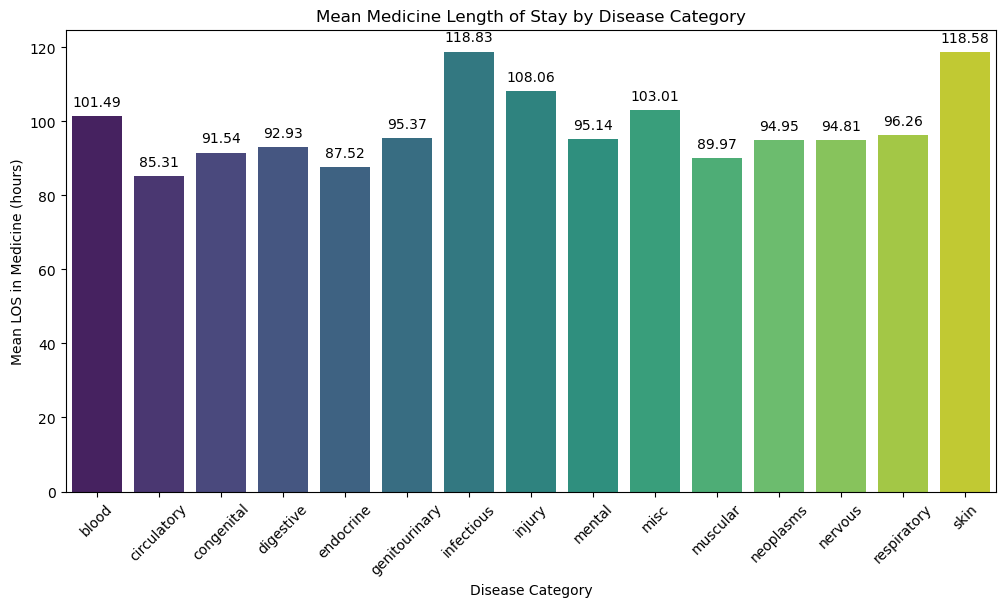

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
bars = sns.barplot(x=list(mean_los.keys()), y=list(mean_los.values()), palette='viridis')


for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}',  # 2 decimal places
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),  
                  textcoords='offset points',
                  ha='center', va='bottom')

plt.xticks(rotation=45)
plt.ylabel('Mean LOS in Medicine (hours)')
plt.xlabel('Disease Category')
plt.title('Mean Medicine Length of Stay by Disease Category')
plt.show()


In [72]:
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59817 entries, 0 to 59816
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   hadm_id             59817 non-null  float64       
 1   LOS_Medicine_hours  59817 non-null  float64       
 2   subject_id          59817 non-null  int64         
 3   is_outlier          59817 non-null  bool          
 4   gender              59817 non-null  object        
 5   anchor_age          59817 non-null  int64         
 6   admittime           59817 non-null  datetime64[ns]
 7   admission_type      59817 non-null  object        
 8   admit_provider_id   59817 non-null  object        
 9   admission_location  59817 non-null  object        
 10  insurance           59817 non-null  object        
 11  marital_status      59817 non-null  object        
 12  race                59817 non-null  object        
 13  admit_hour          59817 non-null  int32     

In [73]:
df_merge2.head()

,hadm_id,LOS_Medicine_hours,subject_id,is_outlier,gender,anchor_age,admittime,admission_type,admit_provider_id,admission_location,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,20000019.0,66.11,10467237,True,F,76,2159-03-20 21:08:00,EW EMER.,P28XL8,EMERGENCY ROOM,...,1,0,1,0,0,0,0,0,1,0
1,20000024.0,18.56,16925328,False,F,84,2151-05-25 21:44:00,EW EMER.,P43DGE,EMERGENCY ROOM,...,0,0,10,0,0,0,0,0,0,0
2,20000034.0,46.23,19430048,True,M,72,2174-05-22 19:13:00,DIRECT OBSERVATION,P28KC2,PHYSICIAN REFERRAL,...,0,0,28,0,0,0,0,0,0,0
3,20000057.0,69.42,11146739,True,F,91,2190-01-15 17:07:00,EU OBSERVATION,P55EL5,EMERGENCY ROOM,...,1,0,8,5,0,4,0,0,2,0
4,20000214.0,50.37,18327790,True,M,68,2114-05-08 13:50:00,EW EMER.,P784FA,PHYSICIAN REFERRAL,...,0,0,13,0,0,0,0,0,0,0


In [74]:
TARGET_COL = "LOS_Medicine_hours"

# Work on a copy to avoid side effects
df_merge2 = df_merge2.copy()

# A) remove invalid / zero / negative stays
df_merge2 = df_merge2[df_merge2[TARGET_COL].notna()].copy()
df_merge2 = df_merge2[df_merge2[TARGET_COL] > 0].copy()

# B) cap at 99th percentile (winsorize)
cap_99 = df_merge2[TARGET_COL].quantile(0.99)
df_merge2["los_capped"] = df_merge2[TARGET_COL].clip(upper=cap_99)

# C) log-transform capped LOS (THIS is the ONLY log transform)
df_merge2["los_log"] = np.log1p(df_merge2["los_capped"])

print("HC rows after cleaning:", len(df_merge2))
print("HC 99th percentile cap (hours):", cap_99)
print(df_merge2[[TARGET_COL, "los_capped", "los_log"]].describe())


HC rows after cleaning: 59810
HC 99th percentile cap (hours): 560.930699999997
       LOS_Medicine_hours    los_capped       los_log
count        59810.000000  59810.000000  59810.000000
mean           101.086200     98.099905      4.112625
std            127.554017     97.834750      1.151573
min              0.010000      0.010000      0.009950
25%             38.010000     38.010000      3.663818
50%             69.300000     69.300000      4.252772
75%            122.980000    122.980000      4.820120
max           9039.230000    560.930700      6.331379


In [75]:
#model

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


X = df_merge2.drop(columns=["LOS_Medicine_hours", "los_capped", "los_log", "hadm_id", "subject_id"], errors="ignore").copy()

y_log = df_merge2["los_log"].astype(float).copy()


if (y_log < 0).any():
    raise ValueError("Found negative los_log values, which should not happen after log1p on positive LOS.")


In [77]:
datetime_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()

for col in datetime_cols:
    dt = pd.to_datetime(X[col], errors="coerce")
    X[col + "_hour"] = dt.dt.hour
    X[col + "_weekday"] = dt.dt.weekday
    X[col + "_month"] = dt.dt.month

X.drop(columns=datetime_cols, inplace=True, errors="ignore")

cat_like = X.select_dtypes(include=["object", "string", "category"]).columns
X[cat_like] = X[cat_like].astype(str)
X[cat_like] = X[cat_like].replace({"nan": np.nan, "NaT": np.nan, "None": np.nan})


In [ ]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


# y_train_log and y_test_log are already log targets.


In [ ]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())   
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0.0   



In [80]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge


rf = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=1)
et = ExtraTreesRegressor(n_estimators=80, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=1)
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)

ridge = Ridge(alpha=1.0, random_state=42)


voting = VotingRegressor(estimators=[("et", et), ("rf", rf), ("ridge", ridge), ("gbr", gbr)])
weighted_voting = VotingRegressor(estimators=[("et", et), ("rf", rf), ("ridge", ridge), ("gbr", gbr)],
                                  weights=[2, 1, 0.5, 3])

models = {
    "Ridge": ridge,
    "RandomForest": rf,
    "ExtraTrees": et,
    "GradientBoostingRegressor": gbr,
    "VotingRegressor": voting,
    "WeightedVotingRegressor": weighted_voting
}


In [ ]:
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    print(f"\nTraining: {name}")
    pipe.fit(X_train, y_train_log)

   
    y_pred_log = pipe.predict(X_test)

    
    y_pred_hours = np.expm1(y_pred_log)
    y_pred_hours = np.clip(y_pred_hours, 0, None)

    
    y_test_hours = np.expm1(y_test_log)

    
    mse = mean_squared_error(y_test_hours, y_pred_hours)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_hours, y_pred_hours)
    r2_hours = r2_score(y_test_hours, y_pred_hours)

    
    r2_log = r2_score(y_test_log, y_pred_log)

    results[name] = {
        "MAE_hours": mae,
        "RMSE_hours": rmse,
        "MSE_hours": mse,
        "R2_hours": r2_hours,
        "R2_log": r2_log
    }

results_df = pd.DataFrame(results).T.sort_values("MAE_hours")
print("\n===== RESULTS (sorted by MAE_hours) =====")
print(results_df)



Training: Ridge

Training: RandomForest

Training: ExtraTrees


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


rf_stack = RandomForestRegressor(
    n_estimators=120,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=1
)

et_stack = ExtraTreesRegressor(
    n_estimators=180,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=1
)

meta = Ridge(alpha=1.0, random_state=42)

simple_stacking = StackingRegressor(
    estimators=[("rf", rf_stack), ("et", et_stack)],
    final_estimator=meta,
    passthrough=False,
    cv=3,
    n_jobs=1
)

stack_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", simple_stacking)
])

print("\nTraining: SimpleStacking")
stack_pipe.fit(X_train, y_train_log)


y_pred_log_stack = stack_pipe.predict(X_test)


y_pred_hours_stack = np.expm1(y_pred_log_stack)
y_pred_hours_stack = np.clip(y_pred_hours_stack, 0, None)

y_test_hours = np.expm1(y_test_log)


mse = mean_squared_error(y_test_hours, y_pred_hours_stack)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_hours, y_pred_hours_stack)
r2_hours = r2_score(y_test_hours, y_pred_hours_stack)


r2_log = r2_score(y_test_log, y_pred_log_stack)

results["SimpleStacking"] = {
    "MAE_hours": mae,
    "RMSE_hours": rmse,
    "MSE_hours": mse,
    "R2_hours": r2_hours,
    "R2_log": r2_log
}

results_df = pd.DataFrame(results).T.sort_values("MAE_hours")
print("\n===== RESULTS (INCLUDING STACKING) =====")
print(results_df)



Training: SimpleStacking


KeyboardInterrupt: 

In [1]:
def end_signature():
    print("="*40)
    print("END OF NOTEBOOK — AT")
    print("="*40)

end_signature()


END OF NOTEBOOK — AT
